# Using clusters to filter the test set

Idea A:

As you know we have been experimenting with the double classifier for uncertainty determination.

In the original pitch for the masters thesis I suggested using unsupervised learning for this so I suggest we also look into this and it would give you another uncertainity method for the masters.

The method would be something like this.

1. Train the supervised algorithm on the training dataset.

2. Use unsupervised learning on the training set and identify clusters of data.

3. Identify the same clusters in the validation dataset and test each cluster individually. Take note of the difference between best and worst performing clusters.

4. Repeat steps 2 and 3 until you find the unsupervised algorithm and hyperparameters with the largest difference between best and worst performing clusters.

5. Identify the same clusters in the test dataset using the unsupervised algorithm and hyperparameters found.

6. Test the supervised algorithm in the test dataset but exclude the worst performing cluster. This should increase accuracy.


In [26]:
%matplotlib inline

In [27]:
import numpy as np
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
sys.path.insert(1, module_path + '/src')

from sktime.utils.data_io import load_from_tsfile_to_dataframe
from sktime.utils.data_processing import from_nested_to_2d_array


from keras.layers import Input, Dense
from keras.models import Model


from sklearn.metrics import f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# ICA and PCA (first 2 components)
from sklearn.decomposition import PCA, FastICA # Principal Component Analysis module

from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


def plot_elbow_dimentionality_reduced_clusters(clustering_approaches):
    fig, axs = plt.subplots(4)
    fig.set_size_inches(10,20)
    for [i, (method, data)] in enumerate(clustering_approaches.items()):
        ks = range(1, 10)
        inertias = []

        for k in ks:
            # Create a KMeans instance with k clusters: model
            model = KMeans(n_clusters=k)

            model.fit(data['train']) 

            # Append the inertia to the list of inertias
            inertias.append(model.inertia_)


        axs[i].plot(ks, inertias, '-o', color='black', linewidth = 1)
        axs[i].set_xlabel('number of clusters, k')
        axs[i].set_ylabel('inertia')
        axs[i].set_title(f'Dimentionality reduction technique = {method}')
        axs[i].set_xticks(ks)

    plt.show() 

def get_trained_encoder(X_train, red_dim = 10):
    '''
    Returns the trained encoder part of a autoencoder
    '''
    encoding_dim = red_dim
    input_layer = Input(shape=(X_train.shape[1],))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(X_train.shape[1], activation='sigmoid')(encoded)

    # let's create and compile the autoencoder
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
    
    X1, X2, Y1, Y2 = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    Y1 = np.asarray(Y1).astype('float32').reshape((-1,1))
    Y2 = np.asarray(Y2).astype('float32').reshape((-1,1))


    autoencoder.fit(X1, Y1,
                    epochs=300,
                    batch_size=200,
                    shuffle=False,
                    verbose = 0,
                    validation_data=(X2, Y2))
    
    
    encoder = Model(input_layer, encoded)
    return encoder


def classify_clusters(X_train, y_train, X_test, y_test, clf, 
                                   dim_red_methods = {'ica': 3,'pca': 3,
                                                      'autoencoder' : 3,'tsne': 3},
                      leave_one_out = False, n_components = 2, plot_elbow = True):
    
    clustering_approaches = {} # Dictionary storing the dimentionality reduced version of the dataset 
    ## ICA 
    if 'ica' in dim_red_methods.keys():
        print('Performing ICA dimentionality reduction')
        ica = FastICA(n_components= n_components)
        ica.fit(X_train)
        clustering_approaches['ica'] = {
            'train': ica.transform(X_train),
            'test': ica.transform(X_test),
            'k' : dim_red_methods['ica']
        }
    
    ## PCA 
    if 'pca' in dim_red_methods.keys():
        print('Performing PCA dimentionality reduction')
        pca = PCA(n_components=n_components)
        pca.fit(X_train)
        clustering_approaches['pca'] = {
            'train': pca.transform(X_train),
            'test': pca.transform(X_test),
            'k' : dim_red_methods['pca']
        }
    ## Autoencoder
    if 'autoencoder' in dim_red_methods.keys():
        print('Performing autoencoder dimentionality reduction, by training autoencoder, and returning encoder')
        encoder = get_trained_encoder(X_train, n_components )
        clustering_approaches['autoencoder'] = {
            'train': encoder.predict(X_train),
            'test': encoder.predict(X_test),
            'k' : dim_red_methods['autoencoder']
        }
    ## TSNE   
    if 'tsne' in dim_red_methods.keys():
        print('Performing TSNE dimentionality reduction')
        clustering_approaches['tsne'] = {
            'train': TSNE(n_components= n_components).fit_transform(X_train),
            'test': TSNE(n_components= n_components).fit_transform(X_test),
            'k' : dim_red_methods['tsne']
        }
        
    ## Make an elbow plot of the dimentionality reduced clusters     
    if plot_elbow and (n_components == 2):
        plot_elbow_dimentionality_reduced_clusters(clustering_approaches)
        
    print('Dimentionality reduction dictionary is found, now training initial classifier')
    ## Finding the initical classifier, and storing its performance
    score_init = {}
    clf_init = clf.fit(X_train, y_train)
    y_pred_init = clf_init.predict(X_test)
    score_init['f1-score'] = f1_score(y_test, y_pred_init)
    score_init['accuracy'] = accuracy_score(y_test, y_pred_init)

    def clustering_based_filter(dim_red_train, dim_red_test, k):
        '''
        Uses the defined dimentionality reduced version of the dataset, with k means clustering, 
        to form clusters in the test set, which are tested seperatly. By either leaving one cluster out, 
        or only including one cluster
        
        
        '''
        model = KMeans(n_clusters=k)
        model.fit(dim_red_train)

        new_y_test = model.predict(dim_red_test)
        cluster_dict = {}
        for cluster in range(k): 
            if leave_one_out:
                cluster_dict[cluster] = np.where(new_y_test != cluster)[0]  # Leave one cluster, test on rest
            else:
                cluster_dict[cluster] = np.where(new_y_test == cluster)[0]  # Only test on the items in the cluster
        metrics = ['accuracy', 'f1-score']
        scores = {k: [] for k in metrics}

        percentage_of_del_idx = []
        for cluster_nr, indices in cluster_dict.items():
            X_test_temp = X_test.iloc[indices]
            y_test_temp = y_test[indices]
            percentage_of_del_idx.append(1 - X_test_temp.shape[0]/X_test.shape[0])
            y_pred = clf_init.predict(X_test_temp)
            scores['accuracy'].append(accuracy_score(y_test_temp, y_pred))
            scores['f1-score'].append(f1_score(y_test_temp, y_pred))

        return scores, percentage_of_del_idx, cluster_dict
    
    scores, per, clusters = {}, {}, {}
    for dim_red, args in clustering_approaches.items():
        print(f'Clustering {dim_red}, and predicting on clusters')
        scores[dim_red], per[dim_red], clusters[dim_red] = clustering_based_filter(args['train'],
                                                                                   args['test'],
                                                                                   args['k'])
    def get_best_performing_cluster_into():
        '''
        Returns a dictionary belonging to each dimentionality reduction technique
        
        '''
        new_scores = {}
        for dim_red, met_dict in scores.items():
            saved_info = {}
            acc_vals = np.array(met_dict['accuracy'])
            f1_vals = np.array(met_dict['f1-score'])
            max_combined_idx = np.argmax(acc_vals + f1_vals)
            saved_info = {
                'best accuracy': acc_vals[max_combined_idx],
                'best f1-score': f1_vals[max_combined_idx],
                'cluster number' : max_combined_idx, 
                'included indices': clusters[dim_red][max_combined_idx],
                'percentage of data removed' : per[dim_red][max_combined_idx]

            }
            new_scores[dim_red] = saved_info
        return new_scores
    
    return score_init, get_best_performing_cluster_into()

In [3]:
X_train, y_train = load_from_tsfile_to_dataframe(module_path + '/features/extracted_features_ts_files/lungsound_preproject_TRAIN.ts')

X_test, y_test = load_from_tsfile_to_dataframe(module_path + '/features/extracted_features_ts_files/lungsound_preproject_TEST.ts')

X_train = from_nested_to_2d_array(X_train)
X_test = from_nested_to_2d_array(X_test)

y_test = y_test.astype(int)
y_train = y_train.astype(int)

X_train.columns = np.arange(len(X_train.columns))
X_test.columns = np.arange(len(X_test.columns))


X_train = X_train.to_numpy()

Performing ICA dimentionality reduction
Performing PCA dimentionality reduction
Performing autoencoder dimentionality reduction, by training autoencoder, and returning encoder
Performing TSNE dimentionality reduction


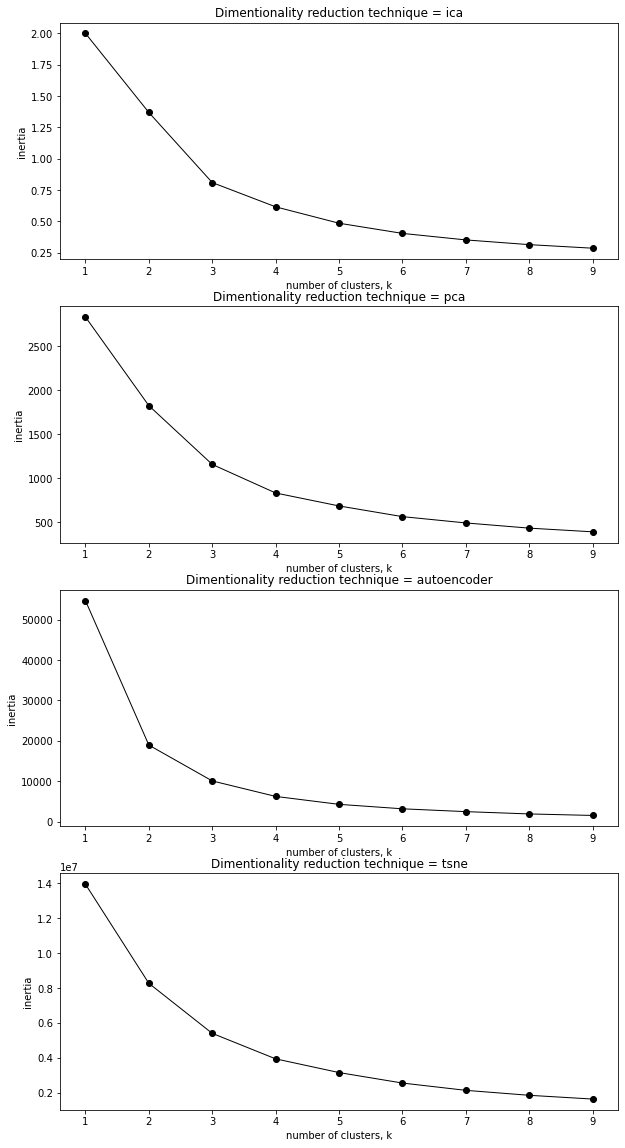

Dimentionality reduction dictionary is found, now training initial classifier
Clustering ica, and predicting on clusters
Clustering pca, and predicting on clusters
Clustering autoencoder, and predicting on clusters
Clustering tsne, and predicting on clusters


In [35]:
from sklearn.neighbors import KNeighborsClassifier


clf = KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=1)
score_init , best_clusters = classify_clusters(X_train, y_train, X_test, y_test, clf, leave_one_out = False)

In [34]:
best_clusters

{'ica': {'best accuracy': 0.8002958579881657,
  'best f1-score': 0.6910755148741419,
  'cluster number': 2,
  'included indices': array([   0,    1,    3,    4,    5,    8,   11,   13,   16,   20,   21,
           23,   25,   27,   29,   30,   33,   34,   38,   39,   40,   44,
           49,   50,   51,   56,   57,   58,   59,   60,   68,   71,   75,
           76,   77,   78,   80,   82,   83,   89,   91,   92,   93,   97,
          107,  109,  113,  114,  116,  118,  122,  127,  129,  130,  131,
          132,  137,  138,  139,  140,  141,  146,  147,  150,  155,  157,
          162,  165,  166,  168,  169,  174,  175,  178,  179,  180,  181,
          184,  189,  190,  191,  192,  194,  196,  197,  198,  200,  201,
          205,  207,  208,  209,  210,  215,  216,  220,  225,  226,  230,
          234,  235,  238,  242,  243,  244,  245,  246,  247,  250,  252,
          258,  261,  263,  264,  265,  268,  270,  273,  274,  275,  276,
          277,  278,  279,  282,  284,  285,  2

In [33]:
score_init

{'f1-score': 0.6960985626283367, 'accuracy': 0.7855072463768116}